https://www.youtube.com/watch?v=aBEkINl2ed4

In [ ]:
!pip install -r requirements.txt

In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import folium
import plotly.express as px
import sklearn
import osmnx as ox
import networkx as nx
from ortools.constraint_solver import routing_enums_pb2
from ortools.constraint_solver import pywrapcp

In [2]:
city = "London"
dtf = pd.read_csv("data/data_stores.csv")
dtf= dtf[dtf["City"]==city][["City", "Street Address", "Latitude", "Longitude"]].reset_index(drop=True)
dtf=dtf.reset_index().rename(columns={"index":"id", "Latitude":"y", "Longitude":"x"})

print("total", len(dtf))
dtf.head(3)

total 216


,id,City,Street Address,y,x
0,0,London,265 Wharncliffe Rd North,42.99,-81.26
1,1,London,"1105 Wellington Rd., Store No. 122",42.93,-81.22
2,2,London,631 Commissioners Road East,42.96,-81.23


In [ ]:
data

In [ ]:
data["id"]

In [3]:
data = dtf.copy()
data["color"] =''
data.loc[data['id'] == 0, 'color'] = 'red'
data.loc[data['id'] != 0, 'color'] = 'black'
start=data[data["id"]==0][["y","x"]].iloc[0].values
print("Starting point:", start)


Starting point: [ 42.99 -81.26]


In [4]:
map = folium.Map(location=start,titles="cartodbpositron" ,zoom_start=12)
data.apply(lambda row:
    folium.CircleMarker(
        location = [row["y"], row["x"]],
        color = row["color"], fill = True, radius = 5).add_to(map), axis=1)
map

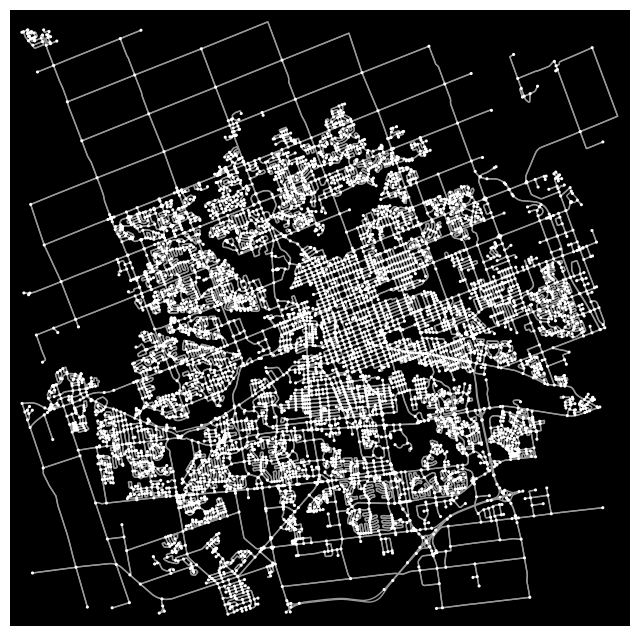

In [5]:
G=ox.graph_from_point(start, dist=10000, network_type="drive")
G=ox.add_edge_speeds(G)
G=ox.add_edge_travel_times(G)
fig, ax = ox.plot_graph(G, bgcolor="black", node_size=5, node_color="white", figsize=(16,8))

In [6]:
start_node = ox.distance.nearest_nodes(G, start[1], start[0])
print(start_node)

289796441


In [7]:
dtf.size

1080

In [8]:
start_node = ox.distance.nearest_nodes(G, start[1], start[0])
dtf["node"]=dtf[["y","x"]].apply(lambda x: ox.distance.nearest_nodes(G,x[1],x[0]),axis=1)
dtf=dtf.drop_duplicates("node", keep='first')
dtf.head()

C:\Users\issam\AppData\Local\Temp\ipykernel_17736\250963677.py:2: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  dtf["node"]=dtf[["y","x"]].apply(lambda x: ox.distance.nearest_nodes(G,x[1],x[0]),axis=1)
C:\Users\issam\AppData\Local\Temp\ipykernel_17736\250963677.py:2: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  dtf["node"]=dtf[["y","x"]].apply(lambda x: ox.distance.nearest_nodes(G,x[1],x[0]),axis=1)
C:\Users\issam\AppData\Local\Temp\ipykernel_17736\250963677.py:2: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent

,id,City,Street Address,y,x,node
0,0,London,265 Wharncliffe Rd North,42.99,-81.26,289796441
1,1,London,"1105 Wellington Rd., Store No. 122",42.93,-81.22,324811692
2,2,London,631 Commissioners Road East,42.96,-81.23,11756886360
3,3,London,1442 Fanshawe Park Road,43.01,-81.34,252974916
4,4,London,"580 Fanshawe Park Road East, Unit 1, White Oak...",43.03,-81.26,302754873


In [9]:
def f(a, b):
    try :
        d = nx.shortest_path_length(G, source=a, target=b, method='dijkstra', weight='travel_time')
    except:
        d=np.nan
    return d

distance_matrix=np.asarray([[f(a,b) for b in dtf["node"].tolist()] for a in dtf["node"].tolist()])
distance_matrix=pd.DataFrame(distance_matrix, columns=dtf["node"].values, index=dtf["node"].values)

distance_matrix.head()

,289796441,324811692,11756886360,252974916,302754873,305539079,347554420,313714330,2600781784,1556562903,4703680516,295523341,313507828,1609033105,312125272,260890490,311486306,3058247625,347336428,7271237232
289796441,0.000000,563.730657,353.913249,594.817995,498.843404,403.787985,127.109964,402.392416,554.359817,102.017771,514.353897,435.980075,233.716763,199.910849,568.316746,227.437165,524.906389,477.334221,1034.800533,1034.966909
324811692,590.760598,0.000000,210.860534,1099.715203,951.832185,709.956097,458.240532,880.632485,736.698015,490.269979,377.118984,891.082077,670.846484,403.347900,679.984523,779.664424,119.624006,982.231429,1308.218159,783.954682
11756886360,379.900063,209.817407,0.000000,913.330533,740.971650,580.292814,247.379998,669.771951,550.313345,279.409445,395.633272,704.697406,459.985949,192.487365,589.079515,581.680813,240.430502,795.846759,1201.962657,916.246284
252974916,592.166096,1096.717460,915.185499,0.000000,429.129572,858.874677,705.433968,332.678585,479.226686,667.061973,726.692800,353.921666,502.197756,766.274200,1084.641203,433.231694,1027.235241,175.018581,1230.599870,978.537385
302754873,498.775194,952.164825,742.347418,430.117561,0.000000,481.084433,573.312479,116.494632,892.416707,513.854412,865.952560,765.488230,348.990194,568.127026,706.850958,395.318205,982.777921,312.633787,852.809625,1391.727406


<function matplotlib.pyplot.show(close=None, block=None)>

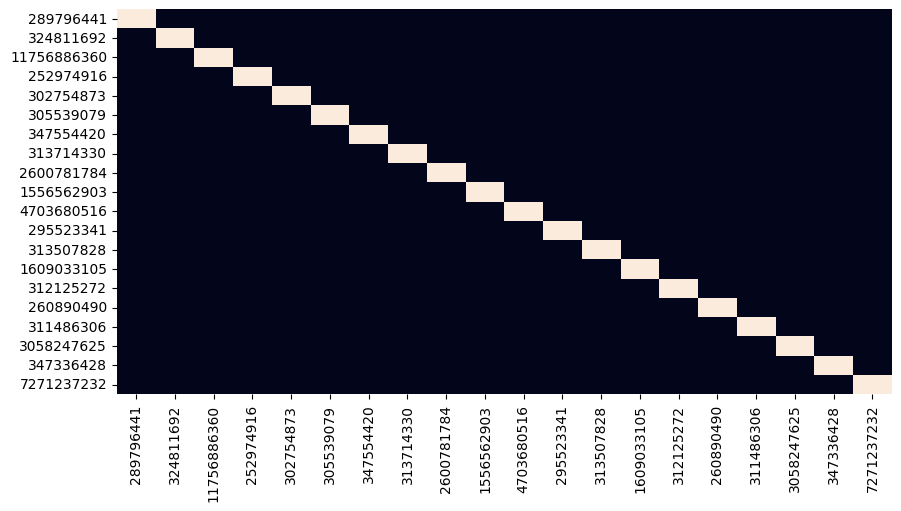

In [10]:
heatmap = distance_matrix.copy()
for col in heatmap.columns:
    heatmap[col] = heatmap[col].apply(lambda x:
        0.3 if pd.isnull(x) else
        (0.7 if np.isinf(x) else
        (0 if x!=0 else 1)))

fig, ax = plt.subplots(figsize=(10,5))
sns.heatmap(heatmap, vmin=0, vmax=1, cbar=False, ax=ax)
plt.show

In [75]:
distance_matrix = distance_matrix.round()
distance_matrix=distance_matrix.astype('int')
distance_matrix.reset_index(drop=True)
distance_matrix.columns=range(len(distance_matrix.columns))
distance_matrix


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
289796441,0,564,354,595,499,404,127,402,554,102,514,436,234,200,568,227,525,477,1035,1035
324811692,591,0,211,1100,952,710,458,881,737,490,377,891,671,403,680,780,120,982,1308,784
11756886360,380,210,0,913,741,580,247,670,550,279,396,705,460,192,589,582,240,796,1202,916
252974916,592,1097,915,0,429,859,705,333,479,667,727,354,502,766,1085,433,1027,175,1231,979
302754873,499,952,742,430,0,481,573,116,892,514,866,765,349,568,707,395,983,313,853,1392
305539079,404,641,584,862,485,0,436,548,895,376,868,768,414,410,309,559,745,744,688,1360
347554420,150,456,246,716,572,436,0,475,519,93,479,518,266,93,491,352,428,599,1067,1000
313714330,401,879,669,332,116,546,475,0,794,416,768,667,251,515,772,297,886,215,918,1294
2600781784,555,732,551,478,887,889,521,791,0,604,362,186,719,578,1003,564,663,633,1520,635
1556562903,170,489,279,668,512,376,93,416,602,0,562,538,206,125,493,337,504,551,1007,1083


In [76]:
drivers = 1
lst_nodes= dtf["node"].tolist()
print("start:", start_node, "total locations to visit", len(lst_nodes)-1, "drivers", drivers)

start: 289796441 total locations to visit 19 drivers 1


In [77]:
manager = pywrapcp.RoutingIndexManager(len(lst_nodes), drivers, lst_nodes.index(start_node))
model=pywrapcp.RoutingModel(manager)

In [78]:
def get_distance(from_index, to_index):
    from_index = manager.IndexToNode(from_index)
    to_index = manager.IndexToNode(to_index)
    return int(distance_matrix.iloc[from_index, to_index])

distance=model.RegisterTransitCallback(get_distance)
model.SetArcCostEvaluatorOfAllVehicles(distance)

parameters = pywrapcp.DefaultRoutingSearchParameters()
parameters.first_solution_strategy = (routing_enums_pb2.FirstSolutionStrategy.PATH_CHEAPEST_ARC)

In [66]:
distance_matrix
get_distance(0,4)

499

In [49]:
int(distance_matrix.iat[0,4]) 
#distance_matrix.at[289796441,302754873]


499

In [79]:
# DIAGNOSTIC CODE - Run this in your notebook

print("=" * 50)
print("STEP 1: Distance Matrix Diagnostics")
print("=" * 50)
print(f"DataFrame shape: {distance_matrix.shape}")
print(f"DataFrame dtypes:\n{distance_matrix.dtypes}")
print(f"Sample value type: {type(distance_matrix.iloc[0, 0])}")
print(f"Sample value: {distance_matrix.iloc[0, 0]}")

print("\n" + "=" * 50)
print("STEP 2: Manager Diagnostics")
print("=" * 50)
print(f"Number of nodes: {manager.GetNumberOfNodes()}")
print(f"Number of vehicles: {manager.GetNumberOfVehicles()}")

print("\n" + "=" * 50)
print("STEP 3: Testing get_distance callback")
print("=" * 50)
try:
    result = get_distance(0, 1)
    print(f"✓ get_distance(0, 1) = {result}, type = {type(result)}")
except Exception as e:
    print(f"✗ ERROR in get_distance: {e}")
    import traceback
    traceback.print_exc()

print("\n" + "=" * 50)
print("STEP 4: Size Check")
print("=" * 50)
matrix_size = len(distance_matrix)
manager_nodes = manager.GetNumberOfNodes()
print(f"Distance matrix size: {matrix_size}")
print(f"Manager nodes: {manager_nodes}")
if matrix_size != manager_nodes:
    print(f"⚠️  SIZE MISMATCH! This is likely your problem!")

STEP 1: Distance Matrix Diagnostics
DataFrame shape: (20, 20)
DataFrame dtypes:
0     int64
1     int64
2     int64
3     int64
4     int64
5     int64
6     int64
7     int64
8     int64
9     int64
10    int64
11    int64
12    int64
13    int64
14    int64
15    int64
16    int64
17    int64
18    int64
19    int64
dtype: object
Sample value type: <class 'numpy.int64'>
Sample value: 0

STEP 2: Manager Diagnostics
Number of nodes: 20
Number of vehicles: 1

STEP 3: Testing get_distance callback
✓ get_distance(0, 1) = 564, type = <class 'int'>

STEP 4: Size Check
Distance matrix size: 20
Manager nodes: 20


In [83]:
solution= model.SolveWithParameters(parameters)

index=model.Start(0)
print('route for driver:')
route_idx, route_distance = [], 0

while not model.IsEnd(index):
    route_idx.append(manager.IndexToNode(index))
    previous_index=index
    index=solution.Value(model.NextVar(index))
    
    try:
        route_distance +=get_distance(previous_index, index)
    except:
        route_distance+=model.GetArcCostForVehicle(from_index=previous_index, to_index=index, vehicle=0)
        
print(route_idx)
print(f'Total distance:{round(route_distance/1000,2)}km')
print(f'Nodes visited: {len(route_idx)}')

route for driver:
[0, 9, 6, 13, 2, 1, 16, 10, 19, 8, 11, 3, 17, 7, 4, 18, 14, 5, 12, 15]
Total distance:6.1km
Nodes visited: 20


In [84]:
print("Route for driver (nodes):")
lst_route=[lst_nodes[i] for i in route_idx]
print(lst_route)

Route for driver (nodes):
[289796441, 1556562903, 347554420, 1609033105, 11756886360, 324811692, 311486306, 4703680516, 7271237232, 2600781784, 295523341, 252974916, 3058247625, 313714330, 302754873, 347336428, 312125272, 305539079, 313507828, 260890490]


In [85]:
def get_path_between_nodes(lst_route):
    lst_paths=[]
    for i in range (len(lst_route)):
        try :
            a , b = lst_nodes[i], lst_nodes[i+1]
        except:
            break
        try:
            path=nx.shortest_path(G, source=a, target=b, method ='dijkstra', weight='travel_time')
            if len(path) > 1:
                lst_paths.append(path)
        except:
            continue
    return lst_paths

lst_paths= get_path_between_nodes(lst_route)

for path in lst_paths:
    ox.plot_route_folium(G, route=path, route_map=map, color="blue", weight=1)
    
map

AttributeError: module 'osmnx' has no attribute 'plot_route_folium'